In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import pymatching
import json
from surface_code_utils import *
import networkx as nx

def plotter(idx_list, color, marker="o"):
    for idx in (idx_list):
        # print(idx, idx_list[f"{idx}"])
        x, y = idx_list[idx]
        plt.plot(x,y,marker= marker,markersize=10,markerfacecolor="None",markeredgecolor=color)
        plt.text(x,y,idx)


# spacetime syndrom graph

In [9]:
d = 4
dx = 2 * d 
dy = d 

qubit_coords = []
for i_y in range(dy):
    for i_x in range(dx):
        if i_x ==0 or i_y == dy - 1:
            qubit_coords.append( ( i_x + 0.5, i_y ) )
        else:
            qubit_coords.append( ( i_x + 0.5, i_y ) )
            qubit_coords.append( ( i_x, i_y + 0.5 ) )


qubit_idx = {}
qubit_idx_to_coords = {}
for idx, coords in enumerate(qubit_coords):
    qubit_idx[f"{coords}"] = idx
    qubit_idx_to_coords[idx] = coords

# plotter(qubit_coords, color="C0")

num_q = len(qubit_coords)
num_s = (dx-1) * dy
s_idx = 0
Smat = np.zeros(( num_s, num_q))
Smat_idx = {}
for i_y in range(dy):
    for i_x in range(1,dx):
        Smat_idx[f"({i_x}, {i_y})"] = s_idx
        if i_y == 0 :
            qvec = [(i_x + 0.5, i_y), (i_x - 0.5, i_y), (i_x, i_y + 0.5)]
        elif i_y == dy - 1 :
            qvec = [(i_x + 0.5, i_y), (i_x - 0.5, i_y), (i_x, i_y - 0.5)]
        else:
            qvec = [(i_x + 0.5, i_y), (i_x - 0.5, i_y), (i_x, i_y - 0.5), (i_x, i_y + 0.5)]
        for q in qvec:
            Smat[s_idx, qubit_idx[f"{q}"]] = 1
        s_idx += 1

qubit_bdy = [qubit_idx[f"({d+0.5}, {i_y})"] for i_y in range(dy)]
S_bdy = [Smat_idx[f"({d}, {i_y})"] for i_y in range(dy)]
bdy = qubit_bdy, S_bdy

qubit_logical = [qubit_idx[f"({0.5}, {i_y})"] for i_y in range(dy)]
logicals = np.zeros(num_q, dtype = np.uint8)
logicals[qubit_logical] = 1

In [10]:
# d = 4
# dx = 2*d
# dy = d 
repetitions = d

qubit_coords_spacetime = []
for i_t in range(repetitions):
    for i_y in range(dy):
        for i_x in range(dx):
            if i_t < repetitions - 1:
                if i_x ==0:
                    qubit_coords_spacetime.append( ( i_x + 0.5, i_y, i_t ) )
                elif i_y == dy - 1:
                    qubit_coords_spacetime.append( ( i_x + 0.5, i_y, i_t ) )
                    qubit_coords_spacetime.append( ( i_x, i_y, i_t + 0.5 ) )
                else:
                    qubit_coords_spacetime.append( ( i_x + 0.5, i_y, i_t ) )
                    qubit_coords_spacetime.append( ( i_x, i_y + 0.5, i_t ) )
                    qubit_coords_spacetime.append( ( i_x, i_y, i_t + 0.5 ) )
            else:
                if i_x ==0:
                    qubit_coords_spacetime.append( ( i_x + 0.5, i_y, i_t ) )
                elif i_y == dy - 1:
                    qubit_coords_spacetime.append( ( i_x + 0.5, i_y, i_t ) )
                else:
                    qubit_coords_spacetime.append( ( i_x + 0.5, i_y, i_t ) )
                    qubit_coords_spacetime.append( ( i_x, i_y + 0.5, i_t ) )

 
qubit_idx_spacetime = {}
qubit_idx_to_coords_spacetime = {}
for idx, coords in enumerate(qubit_coords_spacetime):
    qubit_idx_spacetime[f"{coords}"] = idx
    qubit_idx_to_coords_spacetime[idx] = coords
# plotter(qubit_coords_spacetime, color="C0")
# print(qubit_idx)

num_q_spacetime = len(qubit_coords_spacetime)
print(num_q_spacetime)
# num_q_spacetime = 2* dx* dy
num_s_spacetime = (dx-1) * dy * repetitions
s_idx = 0
# smat = []
Smat_spacetime = np.zeros(( num_s_spacetime, num_q_spacetime))
Smat_idx_spacetime = {}
for i_t in range(repetitions):
    for i_y in range(dy):
        for i_x in range(1,dx):
            Smat_idx_spacetime[f"({i_x}, {i_y}, {i_t})"] = s_idx
            if i_t == 0:
                if i_y == 0 :
                    qvec = [(i_x + 0.5, i_y, i_t), (i_x - 0.5, i_y, i_t), (i_x, i_y + 0.5, i_t),
                            (i_x, i_y, i_t + 0.5)
                            ]
                elif i_y == dy - 1 :
                    qvec = [(i_x + 0.5, i_y, i_t), (i_x - 0.5, i_y, i_t), (i_x, i_y - 0.5, i_t),
                            (i_x, i_y, i_t + 0.5)
                            ]
                else:
                    qvec = [(i_x + 0.5, i_y, i_t), (i_x - 0.5, i_y, i_t), (i_x, i_y + 0.5, i_t),
                            (i_x, i_y - 0.5, i_t), (i_x, i_y, i_t + 0.5)
                            ]
            elif i_t == repetitions - 1:
                if i_y == 0 :
                    qvec = [(i_x + 0.5, i_y, i_t), (i_x - 0.5, i_y, i_t), (i_x, i_y + 0.5, i_t),
                            (i_x, i_y, i_t - 0.5)
                            ]
                elif i_y == dy - 1 :
                    qvec = [(i_x + 0.5, i_y, i_t), (i_x - 0.5, i_y, i_t), (i_x, i_y - 0.5, i_t),
                            (i_x, i_y, i_t - 0.5)
                            ]
                else:
                    qvec = [(i_x + 0.5, i_y, i_t), (i_x - 0.5, i_y, i_t), (i_x, i_y + 0.5, i_t),
                            (i_x, i_y - 0.5, i_t), (i_x, i_y, i_t - 0.5)
                            ]
            else:
                if i_y == 0 :
                    qvec = [(i_x + 0.5, i_y, i_t), (i_x - 0.5, i_y, i_t), (i_x, i_y + 0.5, i_t),
                            (i_x, i_y, i_t + 0.5), (i_x, i_y, i_t - 0.5)
                            ]
                elif i_y == dy - 1 :
                    qvec = [(i_x + 0.5, i_y, i_t), (i_x - 0.5, i_y, i_t), (i_x, i_y - 0.5, i_t),
                            (i_x, i_y, i_t + 0.5), (i_x, i_y, i_t - 0.5)
                            ]
                else:
                    qvec = [(i_x + 0.5, i_y, i_t), (i_x - 0.5, i_y, i_t), (i_x, i_y + 0.5, i_t),
                            (i_x, i_y - 0.5, i_t), (i_x, i_y, i_t + 0.5), (i_x, i_y, i_t - 0.5)
                            ]
            for q in qvec:
                Smat_spacetime[s_idx, qubit_idx_spacetime[f"{q}"]] = 1
            s_idx += 1

296


[ 6  7 11 15 20 22 34 38 41 45 47 48 52]
[ 2  3  6 11 12 14 26 30 31 32 36 39 44 49 51]


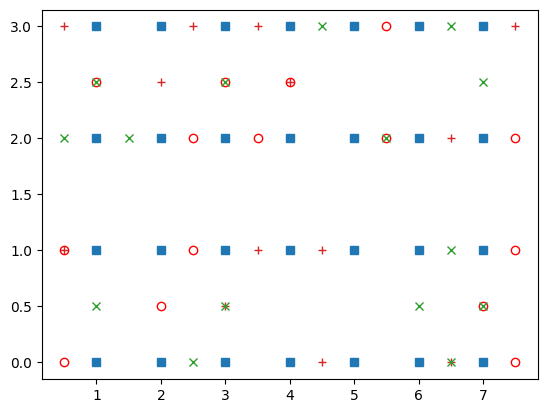

In [18]:
p_err = 0.1
q_err = p_err

matching = Matching(Smat, spacelike_weights=np.log((1-p_err)/p_err),
                repetitions=repetitions, timelike_weights=np.log((1-q_err)/q_err))#, faults_matrix=logicals)
# noise_new = (np.random.rand(num_q, repetitions) < np.reshape(p_qubit_list,(p_qubit_list.shape[0],1))).astype(np.uint8)
noise_new = (np.random.rand(num_q, repetitions) < p_err).astype(np.uint8)
noise_cumulative = (np.cumsum(noise_new, 1) % 2).astype(np.uint8)
noise_total = noise_cumulative[:,-1]
syndrome = Smat@noise_cumulative % 2
# syndrome_error = (np.random.rand(num_s, repetitions) < np.reshape(p_s_list,(p_s_list.shape[0],1)) ).astype(np.uint8)
syndrome_error = (np.random.rand(num_s, repetitions) < q_err ).astype(np.uint8)
syndrome_error[:,-1] = 0 # Perfect measurements in last round to ensure even parity
noisy_syndrome = (syndrome + syndrome_error) % 2
# Convert to difference syndrome
noisy_syndrome[:,1:] = (noisy_syndrome[:,1:] - noisy_syndrome[:,0:-1]) % 2
# recovery_chain = matching.decode(noisy_syndrome)
# print(num_q, num_s, recovery_chain.shape)

weights = np.ones(num_q_spacetime) * np.log((1-p_err)/p_err)
matching_st = Matching(Smat_spacetime, spacelike_weights=weights)
# recovery_st = matching_st.decode(noisy_syndrome)
recovery_st = matching_st.decode(noisy_syndrome.T)
# num_q_in_plane = Smat.shape[1]
recovery_tot = np.zeros(num_q)
for idx, q in enumerate(recovery_st):
    x, y, t = qubit_idx_to_coords_spacetime[idx]
    if t % 1 == 0:
        recovery_tot[qubit_idx[f"({x}, {y})"]] += recovery_st[idx]
recovery_tot %= 2
idx_recovery = np.argwhere(recovery_tot>0)[:,0]
print(idx_recovery)
for q in idx_recovery:
    plt.plot(qubit_coords[q][0],qubit_coords[q][1],"+", color="C3")

rec_rep = matching.decode(noisy_syndrome)
idx_recovery_rep = np.argwhere(rec_rep>0)[:,0]
print(idx_recovery_rep)

for i_y in range(dy):
    for i_x in range(1,dx):
        plt.plot(i_x,i_y, "s", color = "C0")

err_idx = np.argwhere( noise_total > 0 )[:,0]
for q in err_idx:
    plt.plot(qubit_coords[q][0],qubit_coords[q][1],"ro",markerfacecolor="None")

for q in idx_recovery_rep:
    plt.plot(qubit_coords[q][0],qubit_coords[q][1],"x", color="C2")

# print(idx_recovery)

In [17]:
noisy_syndrome.shape

(28, 4)

In [22]:
dist_list = [6,8,10]
p_err_list = np.linspace(0.02, 0.04, 7)
num_errors_st = np.zeros((len(dist_list),len(p_err_list)))
num_errors_rep = np.zeros((len(dist_list),len(p_err_list)))
Niter = 2000

for i_d, d in enumerate(dist_list):
    tic = time.time()
    dx = 1 * d
    dy = d
    code_details = surface_code(dx, dy)
    Smat, logicals, bdy, qubit_idx = code_details
    num_s, num_q = Smat.shape
    qubit_bdy, S_bdy = bdy
    repetitions = d
    # Smat_spacetime, qubit_idx_to_coords_spacetime = surface_code_3d(dx, dy,repetitions)
    Smat_spacetime, _, qubit_idx_mat = surface_code_3d(dx, dy,repetitions)
    qubit_idx_spacetime, qubit_idx_to_coords_spacetime, _ = qubit_idx_mat

    for i_p, p_err in enumerate(p_err_list):
        q_err = p_err

        if i_p == 0:
            matching_rep = Matching(Smat, spacelike_weights=np.log((1-p_err)/p_err),
                            repetitions=repetitions, timelike_weights=np.log((1-q_err)/q_err))#, faults_matrix=logicals)

            weights = np.ones(Smat_spacetime.shape[1]) * np.log((1-p_err)/p_err)
            matching_st = Matching(Smat_spacetime, spacelike_weights=weights)

        for _ in range(Niter):

            noise_new = (np.random.rand(num_q, repetitions) < p_err).astype(np.uint8)
            noise_cumulative = (np.cumsum(noise_new, 1) % 2).astype(np.uint8)
            noise_total = noise_cumulative[:,-1]
            syndrome = Smat@noise_cumulative % 2
            # syndrome_error = (np.random.rand(num_s, repetitions) < np.reshape(p_s_list,(p_s_list.shape[0],1)) ).astype(np.uint8)
            syndrome_error = (np.random.rand(num_s, repetitions) < q_err ).astype(np.uint8)
            syndrome_error[:,-1] = 0 # Perfect measurements in last round to ensure even parity
            noisy_syndrome = (syndrome + syndrome_error) % 2
            # Convert to difference syndrome
            noisy_syndrome[:,1:] = (noisy_syndrome[:,1:] - noisy_syndrome[:,0:-1]) % 2

            recovery_st = matching_st.decode(noisy_syndrome)
            # recovery_st = matching_st.decode(noisy_syndrome.T)
            recovery_tot = np.zeros(num_q)
            for idx, q in enumerate(recovery_st):
                x, y, t = qubit_idx_to_coords_spacetime[idx]
                if t % 1 == 0:
                    recovery_tot[qubit_idx[f"({x}, {y})"]] += recovery_st[idx]
            recovery_tot %= 2
            predicted_logicals_flipped_st = recovery_tot@logicals.T % 2

            rec_rep = matching_rep.decode(noisy_syndrome)
            predicted_logicals_flipped_rep = rec_rep@logicals.T % 2
            actual_logicals_flipped = noise_total@logicals.T % 2
            num_errors_st[i_d,i_p] += not (predicted_logicals_flipped_st == actual_logicals_flipped)
            num_errors_rep[i_d,i_p] += not (predicted_logicals_flipped_rep == actual_logicals_flipped)
    toc = time.time()
    print(f"d={d}, Time elapsed: {toc-tic:.2f} secs")
num_errors_st /= Niter
num_errors_rep /= Niter


d=6, Time elapsed: 9.24 secs
d=8, Time elapsed: 21.64 secs
d=10, Time elapsed: 41.96 secs


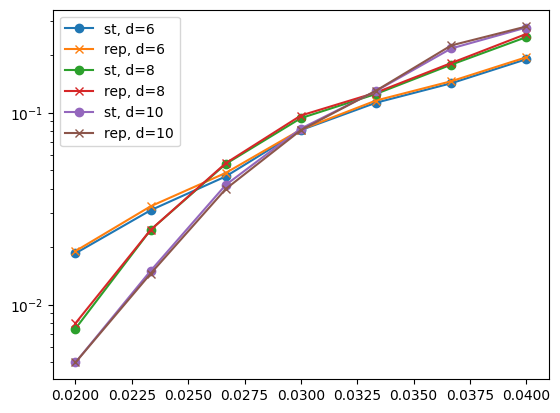

In [23]:
for i_d, d in enumerate(dist_list):
    plt.plot(p_err_list,num_errors_st[i_d,:],"o-",label=f"st, d={d}")
    plt.plot(p_err_list,num_errors_rep[i_d,:],"x-",label=f"rep, d={d}")
plt.legend()
# plt.xscale("log")
plt.yscale("log")

# missing links

In [3]:
def compute_eff_Sx(Sx,loss_inds,remain_inds):
    G_loss = nx.Graph()
    for loss_index in loss_inds:
        s_inds = np.argwhere(Sx[:,loss_index]>0)[:,0]
        # if len(s_inds)>1:
        G_loss.add_edge(s_inds[0],s_inds[1])
        # else:
        #     G_loss.add_node(s_inds[0])

    components = [G_loss.subgraph(c).copy() for c in nx.connected_components(G_loss)]
    lost_vs = []
    for i_c, c in enumerate(components):
        lost_vs += c.nodes()

    num_s = Sx.shape[0]
    remain_vs = list(set(range(num_s)) - set(lost_vs))
    num_stab = len(components)+len(remain_vs)
    Sx_red2 = np.zeros((num_stab,len(remain_inds)))
    Sx_red2[len(components):,:] = Sx[np.ix_(remain_vs,remain_inds)]
    for i_c, c in enumerate(components):
        Sx_red2[i_c,:] = np.sum(Sx[np.ix_(c.nodes(),remain_inds)],axis = 0)%2

    keep_cols = np.argwhere(np.sum(Sx_red2,axis=0)>0)[:,0]
    Sx_red2 = Sx_red2[:,keep_cols]
    qubits_to_plot = remain_inds[keep_cols]

    return Sx_red2, qubits_to_plot

##################
def netx_Sx(Sx_red,overlap,qubits_to_plot, q_idx):
    q_idx_x, q_idx_y, q_idx_t = q_idx
    inds = np.argwhere(overlap>1)
    if len(inds)>0:
        rep_edges = []
        for i_v in inds:
            if i_v[1]>i_v[0]:
                if not (i_v[0] in rep_edges):
                    rep_edges.append(i_v[0])
                if not (i_v[1] in rep_edges):
                    rep_edges.append(i_v[1])

        rep_edges = np.sort(rep_edges).astype(int)
        not_rep_qubits = np.array(list(set(range(np.size(Sx_red,1))) - set(rep_edges)))
        num_not_rep = len(not_rep_qubits)

        ql2 = []
        nl2 = []
        nl_x2 = []
        nl_y2 = []
        nl_t2 = []
        counter = 0
        i = 0 
        overlap2 = overlap[np.ix_(rep_edges,rep_edges)]
        inds_to_keep2 = list(range(len(rep_edges)))
        while counter < len(rep_edges):
            edge = inds_to_keep2[i]
            ovlp_inds = np.argwhere(overlap2[edge,inds_to_keep2[i+1:]]==2)
            # if qubits_to_plot[rep_edges[edge]] %l ==0:
            if q_idx_x[qubits_to_plot[rep_edges[edge]]]%1 ==0.5:
                nl_i_x = 1
                nl_i_y = 0 
                nl_i_t = 0                 
            elif q_idx_y[qubits_to_plot[rep_edges[edge]]]%1 ==0.5:
                nl_i_x = 0
                nl_i_y = 1 
                nl_i_t = 0                 
            else:
                nl_i_x = 0 
                nl_i_y = 0
                nl_i_t = 1                 
            nl_i = len(ovlp_inds)+1

            qlist = qubits_to_plot[rep_edges[np.ix_([ inds_to_keep2[k] for k in i+1+ovlp_inds[:,0]])]]
            # ovlp_inds_x = np.argwhere(qlist %l==0)
            # ovlp_inds_y = np.argwhere(qlist %l >0)
            ovlp_inds_x = np.argwhere(q_idx_x[qlist]%1 ==0.5)
            ovlp_inds_y = np.argwhere(q_idx_y[qlist]%1 ==0.5)
            ovlp_inds_t = np.argwhere(q_idx_t[qlist]%1 ==0.5)
            nl_i_x += len(ovlp_inds_x)
            nl_i_y += len(ovlp_inds_y)
            nl_i_t += len(ovlp_inds_t)
            for j in ovlp_inds[::-1,0]:
                inds_to_keep2.remove(inds_to_keep2[i+1+j])
            ql2.append(np.concatenate(([qubits_to_plot[rep_edges[edge]]],qlist)))
            counter += nl_i
            nl2.append(nl_i)
            nl_x2.append(nl_i_x)
            nl_y2.append(nl_i_y)
            nl_t2.append(nl_i_t)
            i += 1

        num_rep = len(inds_to_keep2)
        nl_x_tot = np.zeros(num_rep+num_not_rep)
        # nl_x_tot[ np.argwhere(qubits_to_plot[not_rep_qubits]%l ==0)  ] = 1 
        nl_x_tot[ np.argwhere(q_idx_x[qubits_to_plot[not_rep_qubits]]%1 ==0.5)  ] = 1 
        nl_x_tot[num_not_rep:] = nl_x2

        nl_y_tot = np.zeros(num_rep+num_not_rep)
        # nl_y_tot[ np.argwhere(qubits_to_plot[not_rep_qubits]%l >0)  ] = 1 
        nl_y_tot[ np.argwhere(q_idx_y[qubits_to_plot[not_rep_qubits]]%1 == 0.5)  ] = 1 
        nl_y_tot[num_not_rep:] = nl_y2

        nl_t_tot = np.zeros(num_rep+num_not_rep)
        nl_t_tot[ np.argwhere(q_idx_t[qubits_to_plot[not_rep_qubits]]%1 == 0.5)  ] = 1 
        nl_t_tot[num_not_rep:] = nl_t2

        nl_tot = np.concatenate((np.ones(num_not_rep),nl2))

        inds_to_keep2 = rep_edges[inds_to_keep2]
        comb_inds = np.concatenate((not_rep_qubits,inds_to_keep2))
        inds_sorted = np.argsort(comb_inds)
        inds_to_keep2 = comb_inds[inds_sorted]
        nl_x_tot = nl_x_tot[inds_sorted]
        nl_y_tot = nl_y_tot[inds_sorted]
        nl_t_tot = nl_t_tot[inds_sorted]
        nl_tot = nl_tot[inds_sorted]
        remain_qubits = qubits_to_plot[inds_to_keep2]
        # Sx_red_netx = Sx_red[:,inds_to_keep]

        ql_tot = []
        rep_count = 0
        for i in inds_sorted:
            if i< num_not_rep:
                ql_tot.append([qubits_to_plot[not_rep_qubits[i]]])
            else:
                ql_tot.append(ql2[rep_count][:])
                rep_count += 1

    else:
        num_qubits = len(qubits_to_plot)
        remain_qubits = qubits_to_plot
        inds_to_keep_2 = list(range(num_qubits))
        
        ql_tot = qubits_to_plot#[]
        # for i in range(num_qubits):
        #     if i< num_not_rep:
        #         ql_tot.append([qubits_to_plot[i]])

        nl_x_tot = np.zeros(num_qubits)
        # nl_x_tot[ np.argwhere(qubits_to_plot%l ==0)  ] = 1 
        nl_x_tot[ np.argwhere(q_idx_x[qubits_to_plot]%1 ==0.5)  ] = 1 
        nl_y_tot = np.zeros(num_qubits)
        # nl_y_tot[ np.argwhere(qubits_to_plot%l >0)  ] = 1 
        nl_y_tot[ np.argwhere(q_idx_y[qubits_to_plot]%1 == 0.5)  ] = 1 
        nl_t_tot = np.zeros(num_qubits)
        # nl_y_tot[ np.argwhere(qubits_to_plot%l >0)  ] = 1 
        nl_t_tot[ np.argwhere(q_idx_t[qubits_to_plot]%1 ==0.5)  ] = 1 

    return remain_qubits, inds_to_keep2, ql_tot, nl_x_tot, nl_y_tot, nl_t_tot
##################


In [87]:
d = 4
repetitions = d
dx = 1 * d
dy = d
code_details = surface_code(dx, dy)
Smat, logicals, bdy, qubit_idx = code_details
num_s, num_q = Smat.shape
qubit_bdy, S_bdy = bdy
Smat_spacetime, qubit_idx_mat = surface_code_3d(dx, dy,repetitions)
qubit_idx_spacetime, qubit_coords_spacetime = qubit_idx_mat
num_q_spacetime = Smat_spacetime.shape[1]
q_idx_x = np.zeros(num_q_spacetime)
q_idx_y = np.zeros(num_q_spacetime)
q_idx_t = np.zeros(num_q_spacetime)
for idx, coords in enumerate(qubit_coords_spacetime):
    # q_idx_x[idx] = qubit_coords_spacetime[idx][0]
    # q_idx_y[idx] = qubit_coords_spacetime[idx][1]
    q_idx_x[idx] = coords[0]
    q_idx_y[idx] = coords[1]
    q_idx_t[idx] = coords[2]
q_idx = q_idx_x, q_idx_y, q_idx_t

prob_l = 0.3
error_loss = np.random.rand(num_s , repetitions)
error_loss[:,-1] = 1
loss_inds_2d = np.argwhere(error_loss < prob_l)
remain_inds_2d = np.argwhere(error_loss >= prob_l)
# print(loss_inds)
loss_inds = np.array([qubit_idx_spacetime[f"({1+ (coords[0]% (dx-1))}, {coords[0]//(dx-1)}, {coords[1]+0.5})"] for coords in loss_inds_2d])
remain_inds = np.array(list( set(range(num_q_spacetime)) - set(loss_inds)))

Sx_red, qubits_to_plot = compute_eff_Sx(Smat_spacetime,loss_inds,remain_inds)

overlap = Sx_red.T@Sx_red
remain_qubits, inds_to_keep, ql, nl_x, nl_y, nl_t = netx_Sx(Sx_red,overlap,qubits_to_plot, q_idx)
# print(nl_x, nl_y)
num_edge = len(remain_qubits) 

remain_coords = [qubit_coords_spacetime[q] for q in remain_qubits]
# plotter(remain_coords, color="C0")

############## error syndrome calculations ######
p_err =  0.12
q_err = 0.05

pl = (1-(1-2*p_err)**nl_x * (1-2*p_err)**nl_y* (1-2*q_err)**nl_t)/2

weights = np.zeros(num_q_spacetime)
weights[remain_qubits] = np.log((1-pl)/pl) 

inds_to_keep_2 = list(range(Sx_red.shape[1]))
for i in range(num_edge):
    edge = inds_to_keep[i]
    ovlp_inds = np.argwhere(overlap[edge,inds_to_keep_2[i+1:]]==2)
    if len(ovlp_inds)>0:
        for j in ovlp_inds[::-1,0]:
            weights[qubits_to_plot[inds_to_keep_2[i+1+j]]] = weights[qubits_to_plot[edge]]

assert len(np.argwhere(weights>0))== len(qubits_to_plot)

if num_edge > 1:
    matching_st = Matching(Smat_spacetime,spacelike_weights=weights)
else:
    print("percolate")


noise_new = (np.random.rand(num_q, repetitions) < p_err).astype(np.uint8)
noise_cumulative = (np.cumsum(noise_new, 1) % 2).astype(np.uint8)
noise_total = noise_cumulative[:,-1]
syndrome = Smat@noise_cumulative % 2
# err_inst = np.random.rand(num_q)
err_idx = np.argwhere(noise_new>0 )

syndrome_error = (np.random.rand(num_s, repetitions) < q_err ).astype(np.uint8)
syndrome_error[:,-1] = 0 # Perfect measurements in last round to ensure even parity
synd_err_idx = np.argwhere(syndrome_error >0 )

noisy_syndrome = (syndrome + syndrome_error) % 2
synd_idx = np.argwhere(noisy_syndrome >0 )

# # Convert to difference syndrome
noisy_syndrome[:,1:] = (noisy_syndrome[:,1:] - noisy_syndrome[:,0:-1]) % 2
synd_idx = np.argwhere(noisy_syndrome >0 )
# print(synd_idx)

recovery_st = matching_st.decode(noisy_syndrome)
idx_recovery = np.argwhere(recovery_st>0)[:,0]
# print(idx_recovery)
    
recovery_tot = np.zeros(num_q)
for idx, q in enumerate(recovery_st):
    x, y, t = qubit_coords_spacetime[idx]
    if t % 1 == 0:
        recovery_tot[qubit_idx[f"({x}, {y})"]] += recovery_st[idx]
recovery_tot %= 2

predicted_logicals_flipped = recovery_tot@logicals.T % 2
actual_logicals_flipped = noise_total@logicals.T % 2
print(actual_logicals_flipped, predicted_logicals_flipped)


1 1.0


In [2]:
##################
def netx_Sx_list(Sx_red,overlap,qubits_to_plot):
    inds = np.argwhere(overlap>1)
    if len(inds)>0:
        rep_edges = []
        for i_v in inds:
            if i_v[1]>i_v[0]:
                if not (i_v[0] in rep_edges):
                    rep_edges.append(i_v[0])
                if not (i_v[1] in rep_edges):
                    rep_edges.append(i_v[1])

        rep_edges = np.sort(rep_edges).astype(int)
        not_rep_qubits = np.array(list(set(range(np.size(Sx_red,1))) - set(rep_edges)))
        num_not_rep = len(not_rep_qubits)

        repeated_inds = []
        counter = 0
        i = 0 
        overlap2 = overlap[np.ix_(rep_edges,rep_edges)]
        inds_to_keep2 = list(range(len(rep_edges)))
        while counter < len(rep_edges):
            edge = inds_to_keep2[i]
            ovlp_inds = np.argwhere(overlap2[edge,inds_to_keep2[i+1:]]==2)
            nl_i = len(ovlp_inds)+1

            qlist = qubits_to_plot[rep_edges[np.ix_([ inds_to_keep2[k] for k in i+1+ovlp_inds[:,0]])]]
            for j in ovlp_inds[::-1,0]:
                inds_to_keep2.remove(inds_to_keep2[i+1+j])
            repeated_inds.append(list(np.concatenate(([qubits_to_plot[rep_edges[edge]]],qlist))))
            counter += nl_i
            i += 1

        inds_to_keep2 = rep_edges[inds_to_keep2]
        comb_inds = np.concatenate((not_rep_qubits,inds_to_keep2))
        inds_sorted = np.argsort(comb_inds)
        inds_to_keep2 = comb_inds[inds_sorted]
        remain_qubits = qubits_to_plot[inds_to_keep2]

    else:
        num_qubits = len(qubits_to_plot)
        remain_qubits = qubits_to_plot
        inds_to_keep_2 = list(range(num_qubits))
        repeated_inds = []
    return remain_qubits, inds_to_keep2, repeated_inds
##################

In [33]:
def plotter(idx_list, color="C0", marker="o"):
    # for idx in (idx_list):
    for idx, coords in enumerate(idx_list):
        # print(idx, idx_list[f"{idx}"])
        x, y, t = coords
        # x, y = idx_list[idx]
        if t < 1:
            if t < 0.5:
                plt.plot(x,y,marker= marker,markersize=10,markerfacecolor="None",markeredgecolor=color)
                plt.text(x,y,idx)
            else:
                plt.plot(x,y,marker= "s",markersize=10,markerfacecolor="None",markeredgecolor="C1")
                plt.text(x,y,idx)

In [74]:
d = 4
repetitions = 4
dx = 2 * d
dy = d
code_details = surface_code(dx, dy)
Smat, logicals, bdy, qubit_idx = code_details
num_s, num_q = Smat.shape
data_bdy, ancilla_bdy = bdy
code_details_3d = surface_code_3d(dx, dy,repetitions)
Smat_spacetime, bdy_spacetime, qubit_idx_mat = code_details_3d
qubit_idx_spacetime, qubit_coords_spacetime, ancilla_idx_st = qubit_idx_mat
num_q_spacetime = Smat_spacetime.shape[1]
data_q_idx = list(set(range(num_q_spacetime))-set(ancilla_idx_st))

# plotter(qubit_coords_spacetime)

prob_l = 0.2
error_loss = np.random.rand(num_s , repetitions)
error_loss[:,-1] = 1
loss_inds_2d = np.argwhere(error_loss < prob_l)
remain_inds_2d = np.argwhere(error_loss >= prob_l)
loss_inds = np.array([qubit_idx_spacetime[f"({1+ (coords[0]% (dx-1))}, {coords[0]//(dx-1)}, {coords[1]+0.5})"] for coords in loss_inds_2d])
# print(loss_inds_2d)
# print(loss_inds)
remain_inds = np.array(list( set(range(num_q_spacetime)) - set(loss_inds)))

Sx_red, qubits_to_plot = compute_eff_Sx(Smat_spacetime,loss_inds,remain_inds)

overlap = Sx_red.T@Sx_red
remain_qubits, inds_to_keep, ql_rep = netx_Sx_list(Sx_red,overlap,qubits_to_plot)
# num_edge = len(remain_qubits) 
# print(ql_rep)


# ############## error syndrome calculations ######
p_bulk_s = 0.01
p_bdy_s = 0.02

p_bulk_qubit = 0.1
p_bdy_qubit = 0.1

p_s_list = np.ones(num_s) * p_bulk_s
p_s_list[ancilla_bdy] = p_bdy_s
p_qubit_list = np.ones(num_q) * p_bulk_qubit
p_qubit_list[data_bdy] = (p_bulk_qubit+ p_bdy_qubit)

data_bdy_st, ancilla_bdy_st = bdy_spacetime
remain_ancilla = np.intersect1d(remain_inds, ancilla_idx_st)
remain_ancilla_bdy = np.intersect1d(remain_inds, ancilla_bdy_st)

p_qubit_st = np.zeros(num_q_spacetime) 
p_qubit_st[data_q_idx] = p_bulk_qubit 
p_qubit_st[data_bdy_st] = (p_bulk_qubit+ p_bdy_qubit) 
p_qubit_st[ancilla_idx_st] = p_bulk_s
p_qubit_st[ancilla_bdy_st] = (p_bulk_s+ p_bdy_s)

# remain_data =np.intersect1d(remain_inds, data_q_idx)
weights = np.zeros(num_q_spacetime)
weights[remain_ancilla] = np.log((1-p_bulk_s)/p_bulk_s) 
weights[remain_ancilla_bdy] = np.log((1-p_bdy_s)/p_bdy_s) 
weights[data_q_idx] = np.log((1-p_bulk_qubit)/p_bulk_qubit) 
weights[data_bdy_st] = np.log((1-p_bdy_qubit)/p_bdy_qubit)

for links in ql_rep:
    # print(links)
    p_eff = (1-np.prod(1-2*p_qubit_st[links]))/2
    weights[links] = np.log((1-p_eff)/p_eff)

assert len(np.argwhere(weights>0))== len(qubits_to_plot)

matching_st = Matching(Smat_spacetime,spacelike_weights=weights)

noise_new = (np.random.rand(num_q, repetitions) < np.reshape(p_qubit_list,(p_qubit_list.shape[0],1))).astype(np.uint8)
noise_cumulative = (np.cumsum(noise_new, 1) % 2).astype(np.uint8)
noise_total = noise_cumulative[:,-1]
syndrome = Smat@noise_cumulative % 2
err_idx = np.argwhere(noise_new>0 )

syndrome_error = (np.random.rand(num_s, repetitions) < np.reshape(p_s_list,(p_s_list.shape[0],1)) ).astype(np.uint8)
syndrome_error[:,-1] = 0 # Perfect measurements in last round to ensure even parity
synd_err_idx = np.argwhere(syndrome_error >0 )

noisy_syndrome = (syndrome + syndrome_error) % 2
synd_idx = np.argwhere(noisy_syndrome >0 )

# # Convert to difference syndrome
noisy_syndrome[:,1:] = (noisy_syndrome[:,1:] - noisy_syndrome[:,0:-1]) % 2
# synd_idx = np.argwhere(noisy_syndrome >0 )
# print(synd_idx)

recovery_st = matching_st.decode(noisy_syndrome)
idx_recovery = np.argwhere(recovery_st>0)[:,0]
# print(idx_recovery)
    
recovery_tot = np.zeros(num_q)
for idx, q in enumerate(recovery_st):
    x, y, t = qubit_coords_spacetime[idx]
    if t % 1 == 0:
        recovery_tot[qubit_idx[f"({x}, {y})"]] += recovery_st[idx]
recovery_tot %= 2

predicted_logicals_flipped = recovery_tot@logicals.T % 2
actual_logicals_flipped = noise_total@logicals.T % 2
print(actual_logicals_flipped, predicted_logicals_flipped)
print(actual_logicals_flipped == predicted_logicals_flipped)


1 1.0
True


## Logical errro vs Physical error 
Here we simulate the logical error probability as a function of physical error probability when each data qubit is subject to depolarizing channel.

In [3]:
# p_bulk_qubit = 0.05
p_bdy_qubit = 0.1
# p_qubit_list = np.ones(num_q) * p_bulk_qubit
# p_qubit_list[qubit_bdy] = p_bdy_qubit

harmonic = lambda k: (1/np.arange(1,k+1)).sum()
bandwidth = 4

p_bulk_s = 0.01
p_bdy_s = 0.02

dist_list = [4,6,8]
gen_coh_ratio_list = np.logspace(-3,-1,8)
Niter = 100
num_errors = np.zeros((len(dist_list),len(gen_coh_ratio_list)))
for i_d, d in enumerate(dist_list):
    # print(d)

    tic = time.time()
    Smat, logicals, bdy = surface_code(d)
    num_s, num_q = Smat.shape
    qubit_bdy, S_bdy = bdy
    p_s_list = np.ones(num_s) * p_bulk_s
    p_s_list[S_bdy] = p_bdy_s

    repetitions = d

    for i_t, ratio in enumerate(gen_coh_ratio_list):
        # print(i_t)
        
        if d > bandwidth:
            idle_time = ((d // bandwidth) * harmonic(bandwidth)  + harmonic (d % bandwidth)  )* ratio
        else:
            idle_time = harmonic(d)* ratio
        p_bulk_qubit = 1 - np.exp(- idle_time )
        p_qubit_list = np.ones(num_q) * p_bulk_qubit
        p_qubit_list[qubit_bdy] = (p_bulk_qubit+ p_bdy_qubit)

        matching = Matching(Smat, spacelike_weights=np.log((1-p_qubit_list)/p_qubit_list),
                        repetitions=repetitions, timelike_weights=np.log((1-p_s_list)/p_s_list), faults_matrix=logicals)
        for _ in range(Niter):
            noise_new = (np.random.rand(num_q, repetitions) < np.reshape(p_qubit_list,(p_qubit_list.shape[0],1))).astype(np.uint8)
            noise_cumulative = (np.cumsum(noise_new, 1) % 2).astype(np.uint8)
            noise_total = noise_cumulative[:,-1]
            syndrome = Smat@noise_cumulative % 2
            syndrome_error = (np.random.rand(num_s, repetitions) < np.reshape(p_s_list,(p_s_list.shape[0],1)) ).astype(np.uint8)
            syndrome_error[:,-1] = 0 # Perfect measurements in last round to ensure even parity
            noisy_syndrome = (syndrome + syndrome_error) % 2
            # Convert to difference syndrome
            noisy_syndrome[:,1:] = (noisy_syndrome[:,1:] - noisy_syndrome[:,0:-1]) % 2
            # recovery_chain = matching.decode(noisy_syndrome)
            # print(num_q, num_s, recovery_chain.shape)
            predicted_logicals_flipped = matching.decode(noisy_syndrome)[0]
            actual_logicals_flipped = noise_total@logicals.T % 2
            num_errors[i_d,i_t] += not (predicted_logicals_flipped == actual_logicals_flipped)
    toc = time.time()
    print(f"d={d}, Time elapsed: {toc-tic:.2f} secs")
num_errors /= Niter
# print(num_errors)
# print(predicted_logicals_flipped, actual_logicals_flipped)

d=4, Time elapsed: 0.08 secs
d=6, Time elapsed: 0.14 secs
d=8, Time elapsed: 0.29 secs
